# Semi-Supervised Learning Models

In [46]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',35)

import warnings
warnings.filterwarnings('ignore')

import itertools, math, time, re, pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

# Modeling Prep

## Load Data

In [13]:
# prelabeled set used for initial training
prelabeled_df = pd.read_csv('data/finalized_data/training')

# unlabeled set used for predictions after initial training
unlabeled_df = pd.read_csv('data/finalized_data/unlabeled')

In [14]:
prelabeled_df.head()

,Player,GP,MIN,PTS,FGA,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,CS_3PA,CS_3P%,PP100Pos,AST %,REB %,USG %,Height,Pos,Class,TEAM
0,Aaron Gordon: 2015,78.0,23.9,9.2,7.4,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,1.7,30.5,18.9,10.3,13.3,16.9,81,PF,7.0,ORL
1,Al Horford: 2015,82.0,32.1,15.2,12.8,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,3.0,35.1,22.9,16.5,10.9,20.2,82,C,3.0,ATL
2,Al Jefferson: 2015,47.0,23.3,12.0,10.7,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,0.0,0.0,25.3,11.4,13.3,24.0,82,C,2.0,CHA
3,Allen Crabbe: 2015,81.0,26.0,10.3,8.4,45.9,3.5,39.3,2.7,1.2,0.8,0.8,0.2,1.7,58.8,3.1,44.8,0.1,1.8,3.2,41.1,19.2,7.2,4.9,15.9,78,SG,1.0,POR
4,Andre Drummond: 2015,81.0,32.9,16.2,13.1,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,0.0,0.0,24.6,4.2,21.7,23.9,83,C,2.0,DET


In [4]:
unlabeled_df.head()

,Player,GP,MIN,PTS,FGA,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,CS_3PA,CS_3P%,PP100Pos,AST %,REB %,USG %,Height,Pos,Class,TEAM
0,Al-Farouq Aminu: 2015,82.0,28.5,10.2,8.8,41.6,4.3,36.1,6.1,1.7,1.5,0.9,0.6,3.4,50.0,1.1,37.6,0.4,3.5,4.0,36.3,17.5,8.7,10.4,16.6,81,SF,NaN,POR
1,Alec Burks: 2015,31.0,25.7,13.3,10.8,41.0,2.5,40.5,3.5,2.0,1.6,0.6,0.1,5.1,47.1,3.1,32.3,0.0,8.0,1.5,40.4,26.1,14.0,6.9,24.6,78,SG,NaN,UTA
2,Alex Len: 2015,78.0,23.3,9.0,8.0,42.3,0.1,14.3,7.6,1.2,1.9,0.5,0.8,5.4,46.3,2.5,32.6,5.0,0.6,0.1,16.7,18.6,8.7,15.6,20.2,85,C,NaN,PHX
3,Alonzo Gee: 2015,73.0,22.4,4.5,3.5,51.8,0.8,28.3,3.4,1.0,0.8,0.9,0.2,2.3,65.2,0.4,25.0,0.1,1.5,0.7,30.2,9.7,6.3,7.3,9.1,78,SF,NaN,NOP
4,Amir Johnson: 2015,79.0,22.8,7.3,5.4,58.5,0.5,23.3,6.4,1.7,1.2,0.7,1.1,4.7,63.8,0.2,37.5,1.2,0.7,0.5,24.3,15.6,11.0,13.2,13.6,81,PF,NaN,BOS


## Model Functions & Metrics

**Build Model Function**

In [100]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True, n_classes=11):
    start = time.time()
    
    # make sure to uncomment the next line for logistic regression
    #clf = OneVsRestClassifier(model)
    
    # comment this next line for logistic regression
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
        
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score

**Plot Feature Importances** 

In [6]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")

**Plot Confusion Matrix**

In [71]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['Miss','Make']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

**Plot Metrics**

In [80]:
def print_model_metrics(y_pred,y_score):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    f1 = f1_score(y_test,y_pred, average='micro')
    
    #print('Training Set Metrics:')
    print('Accuracy: {}\n'.format(round(accuracy,4)))
    print('Micro Precision: {}'.format(round(precision,4)))
    print('Micro Recall: {}'.format(round(recall,4)))
    print('Micro F1: {}\n'.format(round(f1,4)))

    print('Macro Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

## Categorical Variables

In [15]:
X = prelabeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
y = prelabeled_df['Class']

In [19]:
# get dummy variables for position
X = pd.get_dummies(X)
X.head()

,MIN,PTS,FGA,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,CS_3PA,CS_3P%,PP100Pos,AST %,REB %,USG %,Height,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,23.9,9.2,7.4,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,1.7,30.5,18.9,10.3,13.3,16.9,81,0,1,0,0,0
1,32.1,15.2,12.8,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,3.0,35.1,22.9,16.5,10.9,20.2,82,1,0,0,0,0
2,23.3,12.0,10.7,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,0.0,0.0,25.3,11.4,13.3,24.0,82,1,0,0,0,0
3,26.0,10.3,8.4,45.9,3.5,39.3,2.7,1.2,0.8,0.8,0.2,1.7,58.8,3.1,44.8,0.1,1.8,3.2,41.1,19.2,7.2,4.9,15.9,78,0,0,0,0,1
4,32.9,16.2,13.1,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,0.0,0.0,24.6,4.2,21.7,23.9,83,1,0,0,0,0


## Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [45]:
y_train

125    2.0
147    1.0
9      9.0
70     4.0
217    5.0
      ... 
31     2.0
240    3.0
143    4.0
241    5.0
111    2.0
Name: Class, Length: 207, dtype: float64

In [48]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Scale Data
Scaling is done after the train test split in order to ensure that the training set is not influenced at all by the test set.

In [28]:
# scale using MinMaxScaler
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.fit_transform(X_test)

# convert back into DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [29]:
X_train_scaled.head()

,MIN,PTS,FGA,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,CS_3PA,CS_3P%,PP100Pos,AST %,REB %,USG %,Height,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,0.738889,0.731884,0.753769,0.436464,0.102564,0.293,0.468085,0.138614,0.232558,0.166667,0.461538,0.605442,0.683117,0.732673,0.637181,1.000000,0.067308,0.148649,0.296,0.802292,0.162471,0.470297,0.740310,0.7500,1.0,0.0,0.0,0.0,0.0
1,0.644444,0.481884,0.542714,0.157459,0.752137,0.360,0.021277,0.128713,0.186047,0.166667,0.153846,0.278912,0.433766,0.029703,0.599700,0.007194,0.355769,0.891892,0.383,0.504298,0.114416,0.004950,0.457364,0.3125,0.0,0.0,0.0,0.0,1.0
2,0.611111,0.525362,0.577889,0.267956,0.418803,0.387,0.106383,0.227723,0.348837,0.388889,0.076923,0.346939,0.574026,0.405941,0.544228,0.035971,0.355769,0.445946,0.387,0.567335,0.258581,0.113861,0.573643,0.3750,0.0,0.0,0.0,0.0,1.0
3,0.905556,0.731884,0.773869,0.273481,0.299145,0.327,0.163121,1.000000,0.837209,0.944444,0.230769,0.591837,0.545455,0.564356,0.580210,0.014388,0.812500,0.229730,0.359,0.679083,0.938215,0.128713,0.782946,0.3125,0.0,0.0,1.0,0.0,0.0
4,0.877778,0.858696,0.768844,0.378453,0.487179,0.354,0.163121,0.584158,0.767442,0.222222,0.115385,0.503401,0.714286,0.465347,0.691154,0.129496,0.687500,0.310811,0.393,0.796562,0.567506,0.133663,0.763566,0.3750,0.0,0.0,0.0,0.0,1.0


# Stage 1 Modeling

## Logistic Regression

In [49]:
y_train_lb = label_binarize(y_train, classes=[1,2,3,4,5,6,7,8,9,10,11])
y_test_lb = label_binarize(y_test, classes=[1,2,3,4,5,6,7,8,9,10,11])

In [62]:
log_reg, log_y_preds, log_y_score, log_fpr, log_tpr = build_model(LogisticRegression(),
                                                                                X_train_scaled, X_test_scaled,
                                                                                y_train_lb, y_test_lb)

Total Runtime: 0.1763288974761963 seconds


In [ ]:
log_y_preds = np.argmax(log_y_preds, axis=1)

Accuracy: 0.0286

Micro Precision: 0.0286
Micro Recall: 0.0286
Micro F1: 0.0286

Macro Precision: 0.0556
Macro Recall: 0.0213
Macro F1-score: 0.0288

Weighted Precision: 0.1095
Weighted Recall: 0.0286
Weighted F1-score: 0.0423


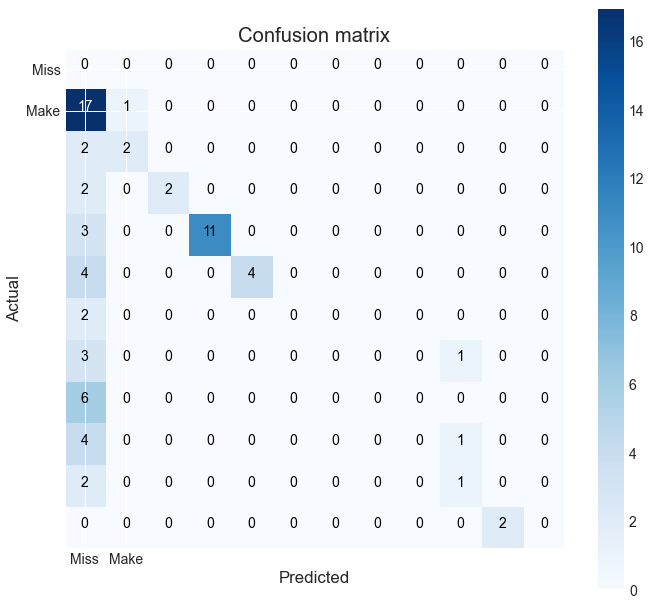

In [81]:
print_model_metrics(log_y_preds, log_y_score)

## Random Forest

In [97]:
rf, rf_y_preds, rf_y_score = build_model(RandomForestClassifier(),
                                                         X_train_scaled, X_test_scaled,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 0.39812302589416504 seconds


Accuracy: 0.6

Micro Precision: 0.6
Micro Recall: 0.6
Micro F1: 0.6

Macro Precision: 0.4486
Macro Recall: 0.5442
Macro F1-score: 0.4712

Weighted Precision: 0.5457
Weighted Recall: 0.6000
Weighted F1-score: 0.5557


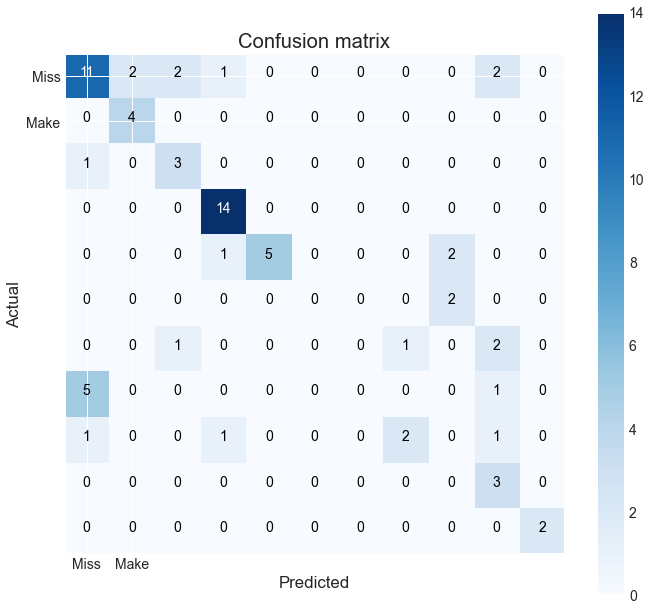

In [98]:
print_model_metrics(rf_y_preds, rf_y_score)

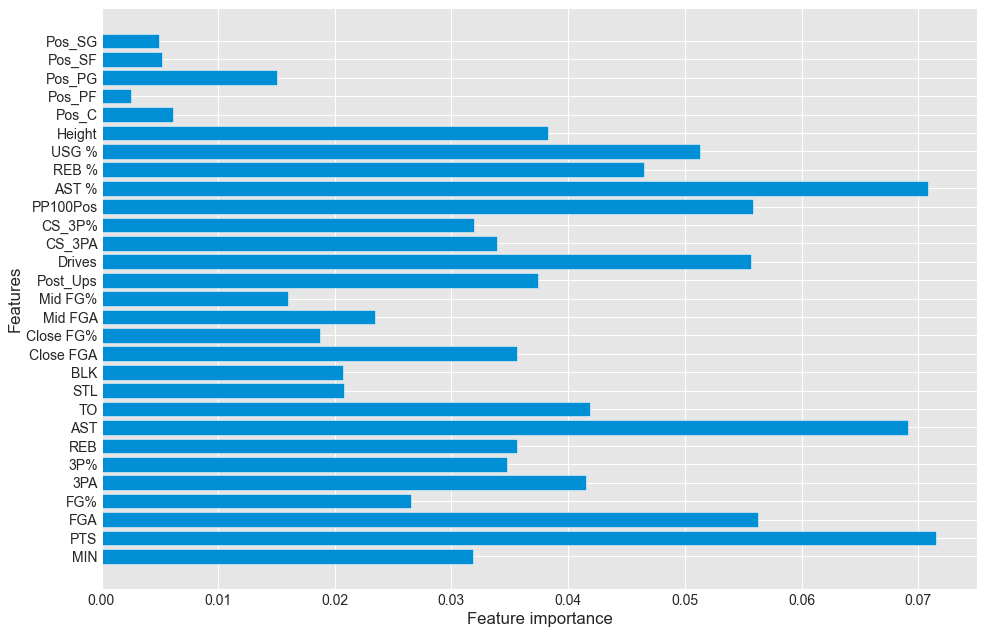

In [99]:
plot_feature_importances(rf)